# DecVTC - Voxels To CLIP Decoder

## Introduction

As artificial intelligence rapidly evolves toward true multimodal understanding, a fundamental question emerges: can we bridge the gap between human cognition and machine learning using the most direct interface possible, the human brain itself? This project explores the ambitious goal of creating a remarkably simple linear decoder that translates neural activity patterns (fMRI voxel data) directly into semantic embeddings. We want to show that even with minimal data and computational complexity, we can achieve cross-modal generalization that mirrors how humans actually understand concepts. By training on brain responses to textual concepts and testing on visual stimuli, we aim to prove that the brain's semantic representations are fundamentally modality-agnostic. In other words, the brain encodes meaning in ways that transcend whether information comes through text, images, or any other sensory channel.

This work represents a crucial step toward machines that understand meaning the way humans do: holistically, across all modalities. As brain imaging technology advances, data becomes more available, and model latency improves, this research pathway could theoretically extend to real-time thought decoding. We're essentially working toward enabling machines to "read minds" by understanding the universal language of neural semantic representation. What we present here isn't just a technical demonstration, but a proof of concept for the future of human-machine interfaces, where the boundary between thought and computation begins to dissolve.

This notebook's purpose is to build a **linear** decoder that takes brain scan data and translates it into the same kind of embeddings that modern AI uses. We want to show that even with a super simple linear model, we can achieve true understanding of concepts regardless of how they're presented to us (text or images).

### Our Hypothesis

Our core hypothesis is that the human brain has a unified representation of meaning that goes beyond how we actually encounter information. In other words, when you think about a "cat," your brain creates the same fundamental pattern whether you're reading the word "cat," seeing a picture of a cat, or even hearing someone talk about cats.

Here's what we're testing: if we train our decoder only on how brains respond to reading words, can it then understand what people are thinking when they look at images of those same concepts? If this works, it would prove that there's a shared "meaning space" in the brain that's completely independent of the sensory channel.

This builds on the groundbreaking work by Pereira et al. (2018), who showed that different concepts create distinct, consistent patterns in brain activity when people read about them. We're taking this a step further by asking: are these same brain patterns active when people see images instead of reading text?

Think about it this way - when you see a picture of a dog and when you read the word "dog," both trigger the same basic understanding in your mind. Your brain somehow knows these are the same concept, even though your eyes processed completely different information. We think this happens because meaning gets stored in a special part of the brain that doesn't care whether the information came from text, images, or any other source.

If we're right, this would be huge for understanding how human thinking works and for building AI that truly understands meaning the way we do. It would mean that concepts in our minds aren't tied to specific senses, but exist as pure ideas that can be triggered by any type of input.

## Text to CLIP

#### Our Plan to Test Cross-Modal Brain Decoding

Our experimental approach is straightforward but powerful. We want to see if the brain really does store meaning in a universal way that doesn't depend on how you encounter information.

**Step 1: Ensure same modality is working**
First, we need to prove we can decode text-based thoughts at all. We'll train our linear decoder on brain scans from people reading concept words, trying to map their neural activity to CLIP text embeddings. This gives us:
- Proof of concept: Can we even do brain→text decoding with modern AI embeddings?
- A baseline: How well does within-modality decoding work?
- Our foundation: The core system we'll test across modalities

If this fails, there's no point testing cross-modal transfer.

**Step 2: The Real Test - Cross-Modal Decoding**
Here's where it gets exciting. We take our text-trained decoder and test it on brain scans from people *looking at images* of the same concepts. We never train on any image brain data - only use it for testing.

If our text-only decoder can figure out what image someone is looking at just from their brain activity, that's strong evidence the brain uses the same patterns for "dog" whether you read the word or see a picture.

#### How We'll Know if It Worked

**Our approach**: 18-fold cross-validation where we hold out 10 concepts per fold. Critically, test concepts never appear in training - no cheating between modalities.

**Our metric**: Rank accuracy (0.5 = chance, 1.0 = perfect). For each brain pattern, how well can our decoder rank the correct concept among all 180 possibilities?

**The bottom line**: We're testing the simplest possible question with the simplest possible model. If cross-modal semantic unity exists in the brain, even basic linear regression should detect it. If it works, we've found evidence that meaning in the brain transcends sensory channels. If not, we learn that semantic representations might be more modality-specific than we thought.

### Setup

#### Dependecies
First, let's download all relevant dependecies to check our hypothesis

In [141]:
# Install dependencies
%pip install ftfy regex tqdm scikit-learn numpy matplotlib seaborn
%pip install -U gdown
%pip install git+https://github.com/openai/CLIP.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

  Cloning https://github.com/openai/CLIP.git to c:\users\user\appdata\local\temp\pip-req-build-lk5jiwum
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\user\AppData\Local\Temp\pip-req-build-lk5jiwum'


#### Data

##### Extract prerequisite data

For this project, we've created a drive folder, containing all of the relevant code and data from the original Pereira et al. paper. Moreover, because the list of concepts and the related images from the original paper is static, we pre-calculated all of the relevant CLIP embeddings (The exact code we used can be seen here in "one_time_drive_setup"), and persisted them to drive. The folder contains:
- The CLIP embeddings for the textual concepts
- The CLIP embedding for all of the photos related to each concept
- The list of concepts
- The actual images for each concept (zipped)
- Relevant fMRI data

All of this data is taken or based (for the embeddings) on the original Pereira paper
Because we wanted the notebook to be available both on local environments (we work on Windows) and on colab (for us and future researchers), we're allowing users to download the data to both windows and linux.

In [142]:
import platform
from pathlib import Path

# If the data already exists, we don't need to download it again
if not Path("data").exists():
    # Check operating system - handlind the data is done differently on Windows and Linux.
    # This will allow us to run the code on Colab, locally, and on any other platform we may choose.
    IS_WINDOWS = platform.system() == "Windows"
    
    if IS_WINDOWS:
        !python -m gdown --folder --id 1CwmFOsYFnq6t33KAzpvw0gaOTQXbcozs -O ./data/
        !powershell -NoProfile -Command "Expand-Archive -Path ./data/experiment-images.zip -DestinationPath ./data/ -Force"
        !powershell -NoProfile -Command "Remove-Item ./data/experiment-images.zip"
    else:
        !gdown --folder --id 1CwmFOsYFnq6t33KAzpvw0gaOTQXbcozs --output ./data
        !unzip ./data/experiment-images.zip
        !rm ./data/experiment-images.zip

##### Translate extracted data to relevant parameters

We'll take the extracted data, all in the "data" folder of the project, and translate it to relevant parameters. This includes:
- Getting the CLIP embeddings for everything
- Getting all concepts 
- Getting fMRI data for textual data

In [143]:
import numpy as np
import scipy.io

# Define constants
TEXT_EMBEDDING_PATH = "data/clip_text_embeddings.npz"
IMAGE_EMBEDDING_PATH = "data/clip_image_embeddings.npz"
CONCEPTS_PATH = "data/concepts.txt"
FMRI_TEXT_PATH = "data/brain-responses-data/examples_180concepts_wordclouds.mat"

# Get the list of all concepts
concepts = np.genfromtxt(CONCEPTS_PATH, dtype=str)

# Get the relevant data for all text embeddings
with np.load(TEXT_EMBEDDING_PATH) as text:
    text_embeddings = text["data"]
    
# Get the relevant data for all image embeddings
with np.load(IMAGE_EMBEDDING_PATH, allow_pickle=True) as imgs:
    img_embeddings = np.asarray(imgs["embeddings"], dtype=np.float32)
    img_concepts = imgs["concepts"]

# Get the fMRI data, specifically for textual imaging
mat = scipy.io.loadmat(FMRI_TEXT_PATH)
fmri_text_data = mat["examples"]

#### Pre-Processing

Here, we'll take the original data we extracted from our drive, and do all the relevant pre-processing steps. These will include:
- Normalizing all vectors (so cosine similarity calculations work properly)
- Making sure all concept labels match up between text and images  
- Grouping multiple image embeddings per concept into single representations
- Selecting the most informative brain voxels for our decoder

##### Centralize concept handling

Before we can work with our data, we need to make sure all our concept labels are consistent. The problem is that concept names might come from different sources with slight formatting differences - things like extra spaces, different capitalization, or encoding issues. We'll also index it - those will come in handy later in multiple occasions

- norm_label(): Cleans up individual concept names by stripping whitespace and converting to lowercase
- index_by_concept()`: Takes all our messy concept names, normalizes them, and creates a clean mapping

This is a basic way to avoid any mistags or phantom whitespaces.


In [144]:
import numpy as np
def norm_label(x) -> str:
    return str(x).strip().lower()

def index_by_concept(concepts: np.ndarray) -> np.ndarray:
    normalized = np.array([norm_label(c) for c in concepts], dtype=str)
    unique_concepts, concept_ids = np.unique(normalized, return_inverse=True)

    return unique_concepts, concept_ids.astype(np.int32)

##### Normalize rows

**row_norm** - This function is getting an ndarray, and normalizing each of it rows. We need this kind of normalization because it's necessary for cosine similarity. Similarly, in CLIP, both the image and text embeddings are being L2-normalized to unit length before computing their similarity. Because of that normalization, when the model uses a dot product, it is exactly equal to cosine similarity. We are going to take a similar route in our calculations, and because the embedding need to be normalized both in training and in inference, that justifies creating a small helper function for them in our opinion.

For epsilon, we'll set it to avoid dividing a vector by zero (the original row of the matrix stays zero, just the norm is capped below by epsilon).

In [145]:
import numpy as np

def row_norm(X: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    nrm = np.linalg.norm(X, axis=1, keepdims=True)
    nrm = np.maximum(nrm, eps)
    return X / nrm

##### Group image embeddings per concept

The parsing of visual data is much more interesting than the textual one. In the dataset supplied by the original Pereira paper, there are 6-7 photos for each concept, all of them describing the concept (in contrast to the text which only has one related embedding vectore - the name of the concept). Because we're working with the high-end model of CLIP, embedding takes quite a bit of time. Moreover, the because the input is the same each time, the output embedding vector is also equal for each individual photo. For those reasons, we chose to separate the embedding itself from the main pipeline, and use it as a baseline. The strategy, though, was to embed and save every single picture for every single concept. This was done because when dealing with multiple inputs, it begs the question of what is the best way to process them for later evaluation. <br>
Specifically, the possible we checked for processing our base image embeddings are:
1. Mean - the "intuitive" way to approach multiple inputs per concept, this is just taking all of the embedding vectors, and averaging each of their components to create one "centralized" one.
2. Medoid - It's a similar way of getting one clustered value from a batch of values, but it differs slightly. Medoid is the data point whose average distance to all other points is smallest.
3. Best of K - This is a third way to look at the data, based on the first two. We'll still calculate the average or the medoid for each concept, but instead of clustering ALL of our data for each concept, we'll the the k best ones. For example, a Best of 3 mean approach would mean we'd take the 3 "best" image-based embedding vectors of the concept, and take their mean as our final embedding vector. The definition of "Best" here would be "Cosine Similarity to the embedding of the single text-based embedding vector of the same concept". The choice of cosine similarity to define closeness is extensively discussed further down the notebook.

We'll implement all three functions to one unified function, so that we can switch out the grouping method easily (this is especially important for ablations, which is out of scope for this project, but can provide a lot of insight, and prove that the model is not working just by chance).

In [146]:
import numpy as np

def group_embeddings_by_concept(
    embeddings: np.ndarray,
    concept_ids: np.ndarray,
    method: str = "mean", # mean/medoid
    k: int | None = None, # for top-k
    anchors: dict[int, np.ndarray] | None = None
) -> np.ndarray:
    concepts = np.unique(concept_ids)
    aggregated_embedding_vectors = []

    for c in concepts:
        E = embeddings[concept_ids == c]

        if k is not None:
            a = anchors[c] if anchors and c in anchors else E.mean(axis=0)
            a = row_norm(a[None, :])[0]
            sims = row_norm(E) @ a
            E = E[np.argsort(-sims)[:min(k, len(E))]]

        if method == "mean":
            vector = E.mean(axis=0)
        elif method == "medoid":
            En = row_norm(E)
            S = En @ En.T
            vector = E[np.argmax(S.mean(axis=1))]
        else:
            raise ValueError(f"Unknown method: {method}")

        aggregated_embedding_vectors.append(vector)

    return np.vstack(aggregated_embedding_vectors)


##### Masking

The original fMRI data gives us ~200,000 voxels of data, but most are just noise. We only actually want the informative voxels. Since we're not nuero-scientist, we won't pretend to understand what parts of the brain are actually relevant for processing each modality and are the most active. We believe that meaning is being interpreted in a way that can be seen using the data from the fMRI, but in a way that has never been modeled before, and cannot be seen without advanced modeling.

We're sticking with Pereira et al.'s approach of using **linear** decoders because:
- If cross-modal semantic unity exists in the brain, even simple linear regression should detect it
- Adding complexity defeats our purpose - we want to test the simplest possible hypothesis
- Linear models are interpretable and show us exactly which brain regions matter

**Our approach:**
1. For each voxel, calculate how well its activity correlates with semantic embeddings
2. Use F-statistics to rank voxels by their predictive power  
3. Keep only the top 5,000 voxels that actually predict meaning
4. Only use text fMRI data for voxel selection

The choice of 5000 voxels follows the original Pereira paper and represents a good balance:
- Enough voxels to capture meaningful semantic patterns
- Few enough to avoid getting overwhelmed by noise
- Computationally manageable for cross-validation

We also really wanted to play with the number of voxels, whether by just sampling some round numbers or by actually learning it (could be done via running an optimizer on the number of different voxels), and we think it's a great ablation to try, but it's out of this project's scope unfortunately.

In [147]:
import numpy as np

def mask_fmri_voxels(fmri_data, semantic_vectors, num_voxels=5000):
    X = np.asarray(fmri_data, dtype=float)
    Y = np.asarray(semantic_vectors, dtype=float)
    if Y.ndim == 1:
        Y = Y[:, None]

    N, V = X.shape
    D = Y.shape[1]
    if N < 2 or V == 0 or D == 0:
        return np.array([], dtype=int)

    # Center once
    Xc = X - X.mean(axis=0, keepdims=True)
    Yc = Y - Y.mean(axis=0, keepdims=True)

    # Sums of squares
    X_ss = np.sum(Xc * Xc, axis=0)
    X_ss[X_ss == 0.0] = np.nan

    # Accumulate per-voxel max F across dims
    voxel_scores = np.full(V, -np.inf, dtype=float)

    # Choose a chunk size
    chunk = min(D, max(64, D // 20))
    for start in range(0, D, chunk):
        end = min(D, start + chunk)
        Yc_chunk = Yc[:, start:end]
        Y_ss = np.sum(Yc_chunk * Yc_chunk, axis=0)
        Y_ss[Y_ss == 0.0] = np.nan

        # corr: (V,d) = (N,V)^T @ (N,d) / sqrt(X_ss[:,None] * Y_ss[None,:])
        denom = np.sqrt(np.outer(X_ss, Y_ss))
        corr = (Xc.T @ Yc_chunk) / denom
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)

        # F = (r^2 / (1 - r^2)) * (N - 2)
        r2 = corr * corr
        r2 = np.clip(r2, 0.0, 1.0 - 1e-12)
        F_chunk = (r2 / (1.0 - r2)) * (N - 2.0)     # (V, d)

        # Update max across dims
        voxel_scores = np.maximum(voxel_scores, F_chunk.max(axis=1))

    k = min(int(num_voxels), V)
    if k <= 0:
        return np.array([], dtype=int)

    top_idx = np.argpartition(voxel_scores, -k)[-k:]
    top_idx = top_idx[np.argsort(voxel_scores[top_idx])[::-1]]
    return top_idx.astype(int)

#### Training

##### Learning the decoder

The elements of the decoder are the parameters we're learning, so this is the heart of the entire paper. Because of that, we wanted to preserve the exact same function from the original Pereira paper - we want a model that's no more complicated then their's
- Ridge regression with cross-validated regularization
- Tests multiple alpha values to find optimal regularization
- No intercept term (we work with centered data)

In [148]:
""" learn_decoder """
import sklearn.linear_model

def learn_decoder(data, vectors):
     """ Given data (a CxV matrix of V voxel activations per C concepts)
     and vectors (a CxD matrix of D semantic dimensions per C concepts)
     find a matrix M such that the dot product of M and a V-dimensional 
     data vector gives a D-dimensional decoded semantic vector. 

     The matrix M is learned using ridge regression:
     https://en.wikipedia.org/wiki/Tikhonov_regularization
     """
     ridge = sklearn.linear_model.RidgeCV(
         alphas=[1, 10, .01, 100, .001, 1000, .0001, 10000, .00001, 100000, .000001, 1000000],
         fit_intercept=False
     )
     ridge.fit(data, vectors)
     return ridge.coef_.T

**Our Wrapper**:

We wrap the original function for several purposes:

1. **Modularity**: Easy to swap in different learning algorithms later
2. **Masking integration**: Automatically applies voxel selection 
3. **Scaling**: Standardizes features for robust training
4. **State management**: Saves scaler and mask for consistent inference

In [149]:
from dataclasses import dataclass
import numpy as np
from sklearn.preprocessing import StandardScaler

@dataclass
class TrainedDecoder:
    W: np.ndarray
    scaler: StandardScaler | None
    mask: np.ndarray | None

def fit_decoder(train_X, train_Y, learn_decoder_fn, use_scaler=True, mask=None):
    scaler = StandardScaler().fit(train_X) if use_scaler else None
    Xs = scaler.transform(train_X) if scaler else train_X
    Xs = Xs[:, mask] if mask is not None else Xs

    W = learn_decoder_fn(Xs, train_Y)
    return TrainedDecoder(W=W, scaler=scaler, mask=mask)

#### Inference

**decoder** - This function is for our inference, and is simply doing the following:
1. Apply the same scaler and mask we've applied in the fit_decoder function. (standardization & feature selection)
2. Doing a dot product on the scaled decoder (the actual "decoding" part).

Again, we're covering our bases here with a generic wrapper, as we want our code to possibly be used in many future research directions.

In [150]:
def decode(model: TrainedDecoder, X: np.ndarray) -> np.ndarray:
    Xs = model.scaler.transform(X) if model.scaler is not None else X
    if model.mask is not None:
        Xs = Xs[:, model.mask]
    return Xs @ model.W

#### Evaluation

For evaluation, we're going to have the following guiding principles:
1. **Distance function (cosine)**. We measure similarity with cosine. In distributional semantics, cosine best reflects semantic relatedness and was explicitly used in Pereira’s pipeline, so our evaluation geometry matches the embedding space and prior work.
2. **K-Fold Cross Validation** - Quality fMRI data is extremely limited. Pereira is still the only open English dataset for fMRI cross-modality, single concept data, similar to what we're trying to model. There are some other alternatives 
    - Allen 672 which is Chinese, 
    - Tuckute 2024, which is for full sentences only, six words each, each of them on no more than 16 participants. 

    That means we were little available data to train on. Because of that fact, we'll choose to evaluate the data using K-Fold Cross Validation - that way, we can train on every piece of data we have, and still evaluate the model. The folding strategy would be as follows - we're going to train a set of 18 decoders, each trained on 170 concepts, and evaluated on the remaining 10 only. The evaluation would be split into two parts:
    - Textual trials (to confirm within-modality performance)
    - Visual trials (to test the hypothesis that text-trained decoders generalize cross-modally)
For the eval, we'll evaluate on the concepts we didn't train on - both on the visual and the textual data. This is to prevent data leakage - nothing about a test concept appears in training.
3. **Primary metric**: rank accuracy (normalized). For each held-out stimulus, we feed its brain image into the decoder to produce a semantic vector (the decoder maps brain→text semantic space), then compare it by cosine to all candidate vectors in the same evaluation set and compute rank accuracy (normalized):
$$
\text{rank\_accuracy} \;=\; 1 \;-\; \frac{\text{rank} - 1}{\#\text{candidates} - 1}
$$
This yields a score in [0, 1] with chance = 0.5, and 1.0 being a perfect decoder.

##### Helper functions

**cosine_rank** - This function is the core of our main metric of evaluation on a single test trial. We get a decoded vector, already a part of the CLIP embedding space, and we get it's true index in the concept list (just an int, indicating it's place in the sorted array of the concepts by name), and all the embeddings of the candidate concepts, compiled to a one big matrix. 

This is a 1-based rank, meaning, we're not going for accuracy of the decoder yet, just how close we are for this specific test case to the true concept. Our calculation will work as follows:
1. Normalize everything (both the decoded vector, and the matrix of all the embedded concepts, so everything that's embedded in our embedding space)
2. Calculate cosine similarity using a dot product (Cosine similarity between two vectors a and b is just the dot product of their unit versions.)
3. Sort all of the cosine similarities in a descending order, to find out where the true_idx sits.

In [151]:
def cosine_rank(decoded_vec: np.ndarray, true_idx: int, candidate_matrix: np.ndarray) -> int:
    dv = decoded_vec / max(np.linalg.norm(decoded_vec), 1e-12)
    Cn = row_norm(candidate_matrix)
    sims = Cn @ dv
    order = np.argsort(-sims)
    return int(np.where(order == true_idx)[0][0] + 1)

**rank_accuracy** - This function is for evaluating a decoder. We outlined our main metric as rank_accuracy, which is: _across all test samples, how accurate is a decoder (1.0 being always correct, 0.5 chance value)_. 

This is exactly what this function does - we're getting all of our decoded test vectors, an array of true indexes for the concepts, and the entire concept embeddings. We then:
1. Calculate the ranks of all of our test decoded vectors.
2. Calculate the accuracy of the decoder, the mean rank, and any other matric we want for that decoder (this function works for a single decoder).

In [152]:
from typing import Dict
def rank_accuracy(
    decoded: np.ndarray,
    true_indices: np.ndarray,
    candidates: np.ndarray
) -> Dict[str, object]:
    ranks = np.array(
        [cosine_rank(decoded[i], int(true_indices[i]), candidates) for i in range(decoded.shape[0])],
        dtype=int
    )
    C = candidates.shape[0]
    mean_rank = float(ranks.mean()) if ranks.size else float('nan')
    
    # Normalize for accuracy metric
    rank_acc = 1.0 - (mean_rank - 1.0) / (C - 1.0) if C > 1 and np.isfinite(mean_rank) else float('nan')
    return {"ranks": ranks, "mean_rank": mean_rank, "rank_accuracy": rank_acc}

All our helper functions work with any kind of embeddings - text, image, or even future modalities. They only care about:
- Vectors can be normalized  
- Cosine similarity makes sense as a distance metric
- The embedding space is semantically meaningful

This gives us (and future researchers) incredible flexibility to extend this work to new domains, embedding spaces, or even different brain imaging techniques.

##### Cross Validation

##### Goal 
Train a set of decoders on fMRI trials from a subset of concepts and evaluate each of them on held-out concepts using rank-based accuracy. The rank is calculated against one or more "candidate" embedding spaces (for example, text and image). Meaning, we'll have the training data (either only text or both text and image) of the subset of concepts we're currently training on, and for the rest, we'll check what the decoder says on them, and compare them to all possible "candidates" from the same modality (if the test is on an image, compare with all of the centralized image embedding vecs)

##### Inputs
- fMRI data per trial
- Target vectors per trial
- Concept id per trial
- Evaluation targets: a dictionary of names to candidate matrices (embedding data)
- A function that constructs the decoder (used during training)
- Optional voxel selection function applied on training data only - for masking
- Optional fold size
- Optional whether to use a scaler (in the fitting of the decoder stage)
- Optional number of voxels to keep (for the masking function)

##### Steps per fold
1. Split by concepts - Build K-folds over unique concepts. The number of splits is derived from the fold size, with shuffling and a fixed random seed.
2. Index rows - Create boolean masks for train and test rows using the concept ids, then slice the train and test sets and keep the test concept ids.
3. Voxel selection if provided - Compute the most informative voxel indices from the training split only and pass them into training to avoid feature-selection misalignment (in smaller words - make sure we only take relevant voxel, and remove noise)
4. Train - Fit the decoder on the training split (with optional scaling and mask). As you can see, the training per fold happens once, and then we evaluate for all of the sets. This is done because the training is usually the longest part, and to avoid code duplication. Here, the decoder is learned as linear, so it doesn't take a lot of time, but if someone were to add non-linearity, or try to make the model more robust, that would probably be the first bottelneck for testing and debugging, so doing it only once is nice.
5. Decode - Run the trained model on the test split to produce predicted vectors.
6. Evaluate - For each evaluation target (e.g., text, image), compute rank accuracy for the held-out trials and store that fold’s metrics. 

##### Output
- A dictionary mapping each evaluation view to a list of per-fold metrics.

This function actually contains quite a lot of our logic behind it, because of the effect we set out to get, of decoding once per fold, and evaluate on everything (text, images) using said decoder. The training (fitting with learn_decoder), inference (decoding) and evalutaion are all parts of this function - each using it's own functions, of course, but still, this function manages a lot of the heavy parts of the pipeline

In [153]:
import numpy as np
from typing import Dict, List
from sklearn.model_selection import KFold
import math
import tqdm

def cross_validate(
    fmri_data: np.ndarray,
    train_targets_per_row: np.ndarray,
    concept_ids: np.ndarray,
    *,
    fold_size: int,
    learn_decoder_fn,
    eval_targets: Dict[str, np.ndarray],
    use_scaler: bool = True,
    mask_fn = None,
    mask_size: int = 5000,
) -> Dict[str, List[Dict[str, object]]]:
    assert eval_targets and isinstance(eval_targets, dict)

    # Prepare result containers
    results: Dict[str, List[Dict[str, object]]] = {name: [] for name in eval_targets.keys()}

    # Build folds 
    unique_concepts = np.unique(concept_ids)
    n_concepts = unique_concepts.size
    n_splits = max(2, math.ceil(n_concepts / max(1, int(fold_size))))
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)

    concept_idx = np.arange(n_concepts)
    folds = list(kf.split(concept_idx))
    
    # Main cross validation loop
    for fold_idx, (train_c_idx, test_c_idx) in enumerate(tqdm.tqdm(folds, desc="Cross-validation folds")):
        train_concepts = set(unique_concepts[train_c_idx])
        test_concepts  = set(unique_concepts[test_c_idx])

        # Row masks for this fold
        train_rows = np.isin(concept_ids, list(train_concepts))
        test_rows  = np.isin(concept_ids, list(test_concepts))

        # Declare training and testing sets
        X_train = fmri_data[train_rows]
        Y_train = train_targets_per_row[train_rows]
        X_test  = fmri_data[test_rows]
        test_ids = concept_ids[test_rows].astype(int)

        # Apply mask
        voxel_indices = None
        if mask_fn is not None:
            voxel_indices = mask_fn(X_train, Y_train, num_voxels=mask_size)

        # Training
        model = fit_decoder(
            train_X=X_train,
            train_Y=Y_train,
            learn_decoder_fn=learn_decoder_fn,
            use_scaler=use_scaler,
            mask=voxel_indices
        )

        # Inference
        decoded = decode(model, X_test)

        # Evaluate
        for view_name, candidate_matrix in eval_targets.items():
            metrics = rank_accuracy(decoded, test_ids, candidate_matrix)
            results[view_name].append(metrics)

    return results

#### Analysis

Our analysis framework is pretty complex, but it's designed to be a one stop place for getting all of the possible analysis one would want on a fMRI decoder model. 

All of these functions are based on the cross validation results, which encapsulate both the rank accuracies and mean ranks across all folds, and they visualize and transform them to provide insight about the performance of the model.

As part of the framework, and why we feel comfortable actually calling it a "framework", we not only support analyzing a single model. Instead, we also allow comparative analysis between two different models, which could later be the basis for much more extensive research on different models to achieve true encoding of "meaning" of language based on fMRI data.

This framework is designed to help us answer the simple questions:
1. Is my model working as intended?
2. Which of my model works _better_?

**setup_plotting_style** - This function configures matplotlib and seaborn with consistent styling parameters for all visualizations, including fonts, colors, and layout settings.

In [154]:
def setup_plotting_style():
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.style.use('default')
    sns.set_palette("Set2")
    plt.rcParams.update({
        'font.size': 11,
        'axes.titlesize': 13,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.titlesize': 16
    })

**calculate_statistics** - This function computes comprehensive statistics for each evaluation type (text/image) from raw cross-validation results, including mean accuracy, standard deviation, rank statistics, and improvement over chance performance. 

We extract rank accuracies and mean ranks from each fold, calculate central tendencies and variability measures, and determine the percentage improvement over random chance (50% accuracy) - The textual metrics at the end of the analysis (which are important!)

In [155]:
def calculate_statistics(results):
    import numpy as np
    
    eval_types = list(results.keys())
    analysis_data = {}
    
    for eval_type in eval_types:
        rank_accs = [fold['rank_accuracy'] for fold in results[eval_type]]
        mean_ranks = [fold['mean_rank'] for fold in results[eval_type]]
        
        mean_acc = np.mean(rank_accs)
        std_acc = np.std(rank_accs)
        mean_rank = np.mean(mean_ranks)
        std_rank = np.std(mean_ranks)
        
        analysis_data[eval_type] = {
            'rank_accuracies': rank_accs,
            'mean_ranks': mean_ranks,
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'mean_rank_value': mean_rank,
            'std_rank': std_rank,
            'min_accuracy': np.min(rank_accs),
            'max_accuracy': np.max(rank_accs),
            'improvement_over_chance': (mean_acc - 0.5) / 0.5 * 100
        }
    
    return analysis_data

**plot_fold_comparison** - This function creates line plots comparing two model's performances across all cross-validation folds for a specific evaluation type, showing fold-by-fold accuracy with chance level reference. 

We use distinct markers and colors for each model. We're also including a horizontal chance line for reference.

In [156]:
def plot_fold_comparison(ax, eval_types, analysis_data, comp_data, eval_type, model_name, comparison_name, fold_numbers, chance_level):
    if eval_type in eval_types:
        main_accs = analysis_data[eval_type]['rank_accuracies']
        comp_accs = comp_data.get(eval_type, {}).get('rank_accuracies', [0]*len(fold_numbers))
        
        ax.plot(fold_numbers, main_accs, 'o-', label=model_name, 
                 linewidth=4, markersize=10, color='#1f77b4', alpha=0.9)
        ax.plot(fold_numbers, comp_accs, 's-', label=comparison_name, 
                 linewidth=4, markersize=10, color='#ff7f0e', alpha=0.9)
        ax.axhline(y=chance_level, color='gray', linestyle='--', alpha=0.8, linewidth=2, label='Chance')
        
        y_min = min(min(main_accs), min(comp_accs)) - 0.02
        y_max = max(max(main_accs), max(comp_accs)) + 0.02
        ax.set_ylim(y_min, y_max)
        
        ax.set_xlabel('Cross-Validation Fold', fontweight='bold', fontsize=12)
        ax.set_ylabel('Rank Accuracy', fontweight='bold', fontsize=12)
        ax.set_title(f'{eval_type.title()} Evaluation Performance', fontweight='bold', fontsize=14)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0.5, len(fold_numbers) + 0.5)

**plot_bar_comparison** - This function generates side-by-side bar charts comparing mean performance between two models across evaluation types, with error bars representing standard deviation and numerical labels for comparison. We include chance level reference line.

In [157]:
def plot_bar_comparison(ax, eval_types, analysis_data, comp_data, model_name, comparison_name, chance_level):
    import numpy as np
    
    x = np.arange(len(eval_types))
    width = 0.35
    
    main_means = [analysis_data[et]['mean_accuracy'] for et in eval_types]
    main_stds = [analysis_data[et]['std_accuracy'] for et in eval_types]
    comp_means = [comp_data.get(et, {}).get('mean_accuracy', 0) for et in eval_types]
    comp_stds = [comp_data.get(et, {}).get('std_accuracy', 0) for et in eval_types]
    
    bars1 = ax.bar(x - width/2, main_means, width, yerr=main_stds, 
                   label=model_name, alpha=0.9, capsize=6, color='#1f77b4', linewidth=2)
    bars2 = ax.bar(x + width/2, comp_means, width, yerr=comp_stds, 
                   label=comparison_name, alpha=0.9, capsize=6, color='#ff7f0e', linewidth=2)
    
    # Add value labels on bars
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        ax.text(bar1.get_x() + bar1.get_width()/2., height1 + main_stds[i] + 0.005,
                f'{height1:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        ax.text(bar2.get_x() + bar2.get_width()/2., height2 + comp_stds[i] + 0.005,
                f'{height2:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax.axhline(y=chance_level, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Chance')
    
    all_means = main_means + comp_means
    y_min = min(all_means) - 0.03
    y_max = max(all_means) + 0.05
    ax.set_ylim(y_min, y_max)
    
    ax.set_xlabel('Evaluation Type', fontweight='bold', fontsize=12)
    ax.set_ylabel('Mean Rank Accuracy', fontweight='bold', fontsize=12)
    ax.set_title('Overall Performance Comparison', fontweight='bold', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([et.title() for et in eval_types], fontsize=11)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

**plot_improvement_bars** - This function creates percentage improvement visualization showing how much better one model performs relative to another, with color-coded positive (green) and negative (red) changes. 

The calculation behind the visualization is relative improvement percentages. We also include a zero reference line to clearly distinguish improvements from degradations in performance (even though the colors should be quite enough I think)

In [158]:
def plot_improvement_bars(ax, eval_types, analysis_data, comp_data, model_name, comparison_name):
    improvements = []
    labels = []
    colors_imp = []
    
    for eval_type in eval_types:
        main_acc = analysis_data[eval_type]['mean_accuracy']
        comp_acc = comp_data.get(eval_type, {}).get('mean_accuracy', 0)
        if comp_acc > 0:
            improvement = ((main_acc / comp_acc) - 1) * 100
            improvements.append(improvement)
            labels.append(f'{eval_type.title()}')
            colors_imp.append('#28a745' if improvement > 0 else '#dc3545')
    
    bars = ax.bar(labels, improvements, color=colors_imp, alpha=0.8, linewidth=2, edgecolor='black')
    
    # Add percentage labels on bars
    for bar, imp in zip(bars, improvements):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height > 0 else -0.5),
                f'{imp:+.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
                fontweight='bold', fontsize=12)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_xlabel('Evaluation Type', fontweight='bold', fontsize=12)
    ax.set_ylabel('Performance Improvement (%)', fontweight='bold', fontsize=12)
    ax.set_title(f'{model_name} Improvement over {comparison_name}', fontweight='bold', fontsize=14)
    ax.grid(True, alpha=0.3, axis='y')
    
    if improvements:
        y_range = max(abs(min(improvements)), max(improvements))
        ax.set_ylim(-y_range * 0.2, y_range * 1.3)

**create_comparison_table** + **style_comparison_table** - The first function is for building a view of different metrics, and comparing them between two models. We show relative improvement/degragation against the model we're comparing _from_ based on the colors (red/green). This function is working with the styling function in order to create a better looking table that would be also understandable for the paper itself.

In [159]:
def create_comparison_table(eval_types, analysis_data, comp_data, model_name, comparison_name):    
    table_data = [
        ['Metric', f'{model_name}', f'{comparison_name}', 'Improvement']
    ]
    
    for eval_type in eval_types:
        main_acc = analysis_data[eval_type]['mean_accuracy']
        main_std = analysis_data[eval_type]['std_accuracy']
        comp_acc = comp_data.get(eval_type, {}).get('mean_accuracy', 0)
        comp_std = comp_data.get(eval_type, {}).get('std_accuracy', 0)
        
        if comp_acc > 0:
            improvement = ((main_acc / comp_acc) - 1) * 100
            
            table_data.append([
                f'{eval_type.title()} Accuracy',
                f'{main_acc:.4f} ± {main_std:.4f}',
                f'{comp_acc:.4f} ± {comp_std:.4f}',
                f'{improvement:+.2f}%'
            ])
        
        # Add mean rank comparison
        main_rank = analysis_data[eval_type]['mean_rank_value']
        main_rank_std = analysis_data[eval_type]['std_rank']
        comp_rank = 90  # Approximate chance level
        rank_improvement = ((comp_rank - main_rank) / comp_rank) * 100
        
        table_data.append([
            f'{eval_type.title()} Mean Rank',
            f'{main_rank:.1f} ± {main_rank_std:.1f}',
            f'~{comp_rank:.0f}',
            f'{rank_improvement:+.1f}%'
        ])
    
    return table_data

def style_comparison_table(table, table_data):
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    
    for i in range(len(table_data[0])):
        table[(0, i)].set_facecolor('#2E86AB')
        table[(0, i)].set_text_props(weight='bold', color='white')
        table[(0, i)].set_height(0.15)
    
    for i in range(1, len(table_data)):
        for j in range(len(table_data[0])):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#F0F8FF')
            else:
                table[(i, j)].set_facecolor('white')
            table[(i, j)].set_height(0.12)
            
            # Highlight improvement column
            if j == 3:
                if '+' in table_data[i][j]:
                    table[(i, j)].set_facecolor('#E8F5E8')
                    table[(i, j)].set_text_props(weight='bold', color='#2E7D2E')

**plot_compaison_visualizations** - This functions creates the visual home for the main 2x2 comparison layout. In the layout, we're showing text evaluation performance, image evaluation performance, overall performance bars, and improvement metrics.

In [160]:
def plot_comparison_visualizations(analysis_data, comp_data, eval_types, model_name, comparison_name, fold_numbers, chance_level, save_plots, plot_dir):
    import matplotlib.pyplot as plt
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle(f'{model_name} vs {comparison_name} Performance Comparison', 
                fontsize=18, fontweight='bold', y=0.98)
    
    # Plot comparisons
    plot_fold_comparison(ax1, eval_types, analysis_data, comp_data, 'text', model_name, comparison_name, fold_numbers, chance_level)
    plot_fold_comparison(ax2, eval_types, analysis_data, comp_data, 'image', model_name, comparison_name, fold_numbers, chance_level)
    plot_bar_comparison(ax3, eval_types, analysis_data, comp_data, model_name, comparison_name, chance_level)
    plot_improvement_bars(ax4, eval_types, analysis_data, comp_data, model_name, comparison_name)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if save_plots:
        plt.savefig(f"{plot_dir}/{model_name.replace(' ', '_').lower()}_vs_{comparison_name.replace(' ', '_').lower()}_comparison.png", 
                   dpi=300, bbox_inches='tight')
    
    plt.show()

**plot_comparison_table** - This function is responsible for running the table functions we saw earlier, and actually displaying it on the screen.

In [161]:
def plot_comparison_table(eval_types, analysis_data, comp_data, model_name, comparison_name, save_plots, plot_dir):
    import matplotlib.pyplot as plt
    
    fig_table, ax_table = plt.subplots(1, 1, figsize=(12, 8))
    ax_table.axis('off')
    
    table_data = create_comparison_table(eval_types, analysis_data, comp_data, model_name, comparison_name)
    
    table = ax_table.table(cellText=table_data[1:], colLabels=table_data[0],
                          cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    
    style_comparison_table(table, table_data)
    
    ax_table.set_title(f'Detailed Performance Comparison: {model_name} vs {comparison_name}', 
                      fontsize=16, fontweight='bold', pad=30)
    
    if save_plots:
        plt.savefig(f"{plot_dir}/{model_name.replace(' ', '_').lower()}_vs_{comparison_name.replace(' ', '_').lower()}_table.png", 
                   dpi=300, bbox_inches='tight')
    
    plt.show()

**plot_single_model_fold_performance** - This function visualizes single model performance across all folds with separate colored lines for each evaluation type, including dotted horizontal lines showing mean performance for each type. We also include chance level for reference.

In [162]:
def plot_single_model_fold_performance(ax, eval_types, analysis_data, fold_numbers, colors, chance_level):
    for i, (eval_type, color) in enumerate(zip(eval_types, colors)):
        rank_accs = analysis_data[eval_type]['rank_accuracies']
        mean_acc = analysis_data[eval_type]['mean_accuracy']
        ax.plot(fold_numbers, rank_accs, 'o-', label=f'{eval_type.title()}', 
               linewidth=3, markersize=8, color=color, alpha=0.8)
        ax.axhline(y=mean_acc, color=color, linestyle=':', alpha=0.7, linewidth=2)
    
    ax.axhline(y=chance_level, color='gray', linestyle='--', alpha=0.8, linewidth=2, label='Chance (0.5)')
    ax.set_xlabel('Cross-Validation Fold', fontweight='bold')
    ax.set_ylabel('Rank Accuracy', fontweight='bold')
    ax.set_title(f'Performance by Fold', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0.5, len(fold_numbers) + 0.5)

**plot_single_model_boxplots** - This function generates box plots showing performance distribution for each evaluation type, revealing variability, outliers, median performance, and quartile ranges relative to chance level. 

For achieveing this sort of visualization, we're using notched boxes to show confidence intervals around medians, includes mean markers, and applying consistent color coding to match other visualizations in the analysis suite.

In [163]:
def plot_single_model_boxplots(ax, eval_types, analysis_data, colors, chance_level):
    box_data = [analysis_data[eval_type]['rank_accuracies'] for eval_type in eval_types]
    bp = ax.boxplot(box_data, labels=[et.title() for et in eval_types], patch_artist=True, 
                    notch=True, showmeans=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.axhline(y=chance_level, color='gray', linestyle='--', alpha=0.7, linewidth=2)
    ax.set_ylabel('Rank Accuracy', fontweight='bold')
    ax.set_title('Performance Distribution', fontweight='bold')
    ax.grid(True, alpha=0.3)

**plot_single_model_mean_ranks** - This function creates line plots of mean ranking performance across folds, where lower ranks indicate better performance (rank 1 = perfect, rank 90 ≈ chance). This is the complementary for the rank_accuracy visualization, as it shows it before the normalization to accuracy (0 to 1). Like always, we present chance level.

In [164]:
def plot_single_model_mean_ranks(ax, eval_types, analysis_data, fold_numbers, colors):
    for i, (eval_type, color) in enumerate(zip(eval_types, colors)):
        mean_ranks = analysis_data[eval_type]['mean_ranks']
        ax.plot(fold_numbers, mean_ranks, 'o-', label=f'{eval_type.title()}', 
               linewidth=2.5, markersize=7, color=color, alpha=0.8)
    
    ax.axhline(y=90, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Chance (~90)')
    ax.set_xlabel('Fold Number', fontweight='bold')
    ax.set_ylabel('Mean Rank (Lower = Better)', fontweight='bold')
    ax.set_title('Mean Rank Performance', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0.5, len(fold_numbers) + 0.5)

**plot_performance_gap_or_summary** - This function displays either cross-modal performance gaps between text and image evaluation (if multiple types available) or a statistical summary table (if only one evaluation type). 

For gaps, we uses colored bars to show positive/negative differences; for summaries, we create a formatted table with key statistics including accuracy ranges and improvement metrics.

In [165]:
def plot_performance_gap_or_summary(ax, eval_types, analysis_data, fold_numbers):
    import numpy as np
    
    if len(eval_types) >= 2:
        eval_type_1, eval_type_2 = eval_types[0], eval_types[1]
        performance_gap = (np.array(analysis_data[eval_type_1]['rank_accuracies']) - 
                          np.array(analysis_data[eval_type_2]['rank_accuracies']))
        colors_gap = ['#28a745' if gap > 0 else '#dc3545' for gap in performance_gap]
        bars = ax.bar(fold_numbers, performance_gap, alpha=0.8, color=colors_gap, 
                      edgecolor='black', linewidth=0.5)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax.set_xlabel('Fold Number', fontweight='bold')
        ax.set_ylabel(f'Performance Gap\n({eval_type_1.title()} - {eval_type_2.title()})', fontweight='bold')
        ax.set_title('Cross-Modal Performance Gap', fontweight='bold')
        ax.legend(['Performance Gap'], loc='upper right')
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_xlim(0.5, len(fold_numbers) + 0.5)
    else:
        # Single evaluation type summary table
        ax.axis('off')
        eval_type = eval_types[0]
        data = analysis_data[eval_type]
        
        summary_data = [
            ['Metric', 'Value'],
            ['Mean Accuracy', f"{data['mean_accuracy']:.4f} ± {data['std_accuracy']:.4f}"],
            ['Range', f"[{data['min_accuracy']:.4f}, {data['max_accuracy']:.4f}]"],
            ['Mean Rank', f"{data['mean_rank_value']:.1f} ± {data['std_rank']:.1f}"],
            ['Improvement', f"{data['improvement_over_chance']:+.1f}%"]
        ]
        
        table = ax.table(cellText=summary_data[1:], colLabels=summary_data[0],
                         cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)
        
        for i in range(len(summary_data[0])):
            table[(0, i)].set_facecolor('#E8E8E8')
            table[(0, i)].set_text_props(weight='bold')
        
        for i in range(1, len(summary_data)):
            for j in range(len(summary_data[0])):
                if i % 2 == 0:
                    table[(i, j)].set_facecolor('#F8F8F8')
        
        ax.set_title(f'{eval_type.title()} Statistical Summary', fontsize=12, fontweight='bold')


**plot_single_model_analysis** - This function is for handling everything related to the creation of the main figure, which is the 2x2 main analysis described earlier.

In [166]:
def plot_single_model_analysis(analysis_data, eval_types, fold_numbers, colors, chance_level, model_name, save_plots, plot_dir):
    import matplotlib.pyplot as plt
    
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig1.suptitle(f'{model_name} Analysis', fontsize=16, fontweight='bold', y=0.98)
    
    plot_single_model_fold_performance(ax1, eval_types, analysis_data, fold_numbers, colors, chance_level)
    plot_single_model_boxplots(ax2, eval_types, analysis_data, colors, chance_level)
    plot_single_model_mean_ranks(ax3, eval_types, analysis_data, fold_numbers, colors)
    plot_performance_gap_or_summary(ax4, eval_types, analysis_data, fold_numbers)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if save_plots:
        plt.savefig(f"{plot_dir}/{model_name.replace(' ', '_').lower()}_analysis.png", 
                   dpi=300, bbox_inches='tight')
    
    plt.show()

**print_comparison_summary** - This is a small helper function for summarizing all metric when comparing models. The report is purely textual here, making results easier to work with in downstream tasks (graphs are much harder, because reading text is much easier than computer vision).

In [167]:
def print_comparison_summary(eval_types, analysis_data, comp_data, model_name, comparison_name):
    print(f"\n{'='*80}")
    print(f"{model_name.upper()} VS {comparison_name.upper()} COMPARISON")
    print('='*80)
    
    for eval_type in eval_types:
        if eval_type in comp_data:
            main_acc = analysis_data[eval_type]['mean_accuracy']
            comp_acc = comp_data[eval_type]['mean_accuracy']
            improvement = ((main_acc / comp_acc) - 1) * 100 if comp_acc > 0 else float('inf')
            print(f"\n{eval_type.upper()} EVALUATION:")
            print(f"{model_name}: {main_acc:.4f} ± {analysis_data[eval_type]['std_accuracy']:.4f}")
            print(f"{comparison_name}: {comp_acc:.4f} ± {comp_data[eval_type]['std_accuracy']:.4f}")
            print(f"Improvement: {improvement:+.2f}%")

    print('='*80)


**print_single_model_summary** -This function prints text summary of single model performance including mean accuracy with standard deviation, performance ranges showing best and worst folds, rank statistics, and percentage improvement over chance level.

In short, same as the comparison summary but for the single model version of the analysis.

In [168]:
def print_single_model_summary(eval_types, analysis_data, model_name):
    print(f"\n{'='*80}")
    print(f"{model_name.upper()} ANALYSIS SUMMARY")
    print('='*80)
    
    for eval_type in eval_types:
        data = analysis_data[eval_type]
        print(f"\n{eval_type.upper()} EVALUATION:")
        print(f"  Mean Accuracy: {data['mean_accuracy']:.4f} ± {data['std_accuracy']:.4f}")
        print(f"  Range: [{data['min_accuracy']:.4f}, {data['max_accuracy']:.4f}]")
        print(f"  Mean Rank: {data['mean_rank_value']:.1f} ± {data['std_rank']:.1f}")
        print(f"  Improvement: {data['improvement_over_chance']:+.1f}% over chance")

    print('='*80)

**analyze_fmri_model** - Finally (really, that took a while), this function is our endpoint to interact with all of the analysis framework we built here. 

It automatically determines whether to perform single model analysis or comparative analysis based on input parameters, coordinates all visualization and statistical functions, and returns comprehensive analysis results including transfer efficiency metrics between modalities. 

It further handles file management, calls appropriate analysis pipelines, and packages all results into a structured output for further use or reporting.

In [169]:
def analyze_fmri_model(results, model_name="fMRI Decoder", 
                      comparison_results=None, comparison_name="Baseline",
                      save_plots=False, plot_dir="./plots"):
    from pathlib import Path
    import numpy as np
    
    if save_plots:
        Path(plot_dir).mkdir(exist_ok=True)
    
    setup_plotting_style()
    
    # Calculate comprehensive statistics
    analysis_data = calculate_statistics(results)
    eval_types = list(results.keys())
    fold_numbers = range(1, len(analysis_data[eval_types[0]]['rank_accuracies']) + 1)
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'][:len(eval_types)]
    chance_level = 0.5
    
    # Handle comparison vs single model analysis
    if comparison_results is not None:
        # Extract comparison data
        comp_data = {}
        for eval_type in eval_types:
            if eval_type in comparison_results:
                comp_rank_accs = [fold['rank_accuracy'] for fold in comparison_results[eval_type]]
                comp_data[eval_type] = {
                    'rank_accuracies': comp_rank_accs,
                    'mean_accuracy': np.mean(comp_rank_accs),
                    'std_accuracy': np.std(comp_rank_accs)
                }
        
        # Create comparison visualizations
        plot_comparison_visualizations(analysis_data, comp_data, eval_types, model_name, 
                                      comparison_name, fold_numbers, chance_level, save_plots, plot_dir)
        plot_comparison_table(eval_types, analysis_data, comp_data, model_name, 
                             comparison_name, save_plots, plot_dir)
        print_comparison_summary(eval_types, analysis_data, comp_data, model_name, comparison_name)
        
    else:
        # Single model analysis
        plot_single_model_analysis(analysis_data, eval_types, fold_numbers, colors, 
                                   chance_level, model_name, save_plots, plot_dir)
        print_single_model_summary(eval_types, analysis_data, model_name)
        comp_data = None
    
    # Return analysis results
    return {
        'model_name': model_name,
        'evaluation_data': analysis_data,
        'comparison_data': comp_data,
        'transfer_analysis': {
            'efficiency': (analysis_data['image']['mean_accuracy'] / analysis_data['text']['mean_accuracy']) * 100 if 'text' in eval_types and 'image' in eval_types else None,
            'gap': analysis_data['text']['mean_accuracy'] - analysis_data['image']['mean_accuracy'] if 'text' in eval_types and 'image' in eval_types else None
        } if 'text' in eval_types and 'image' in eval_types else None
    }

#### Full Pipeline

##### Goal
Now, we have all of our moving parts! We prepped our data, and declared all the functions necessary to evaluate the model. As stated earlier, we wanted to achieve a fact of functional building, meaning, that people can just take our code, and build on it easily (and as we'll discuss later, there's a lot of really interesting directions to go, things we wanted to do ourselves but were out of the scope of this particular project). For that, we really wanted to create a centralized pipeline, one that people can just take, plug in their own parameters, and evaluate new models. We also worked really hard on making the pipeline both fast and logically sound, vectorizing everything along the way and achieving relatively short training time (Which we know very well by ourselves that is a big pain point in data science research).

Originally, we built this function only for the Text to CLIP model we're currently overviewing, but as we saw, the results were far from satisfactory (which also tells us many things and more, so that's still exciting! Just not in the "traditional" way). Because of that, we went on with our research and strived to achieve better results, and this function had to change a little, but it proved to be extremely useful, exactly like we wanted it to be!

As explained above, this function is very heavy on the pre-processing part, because most of the logic is hidden here behind the cross_validate function. So, the things that we need to do here is to take our original data, the one we extracted far far at the beginning of this notebook, and convert it into everything we need to get a model and evaluate it using the cross val function. 

##### Inputs
Our inputs here are a mix of functions we've declared along the way, and data we've extracted directly from the drive folder. Moreover, there are some that are related to the multi modal flag - we'll explain that shortly.
- **text_embeddings** - CLIP text embeddings for all 180 concepts, normalized to unit length
- **img_embeddings** - CLIP image embeddings for all images across concepts (6-7 images per concept)
- **img_concepts** - Array of concept labels corresponding to each image embedding
- **concepts** - Array of concept names for the text embeddings
- **fmri_text** - fMRI brain activity data from participants reading text stimuli (180 trials, V voxels)
- **grouping_method** - The grouping method for aggregating multiple embeddings of the same concept (mean/medoid)
- **learn_decoder_fn** - A Function that learns the linear mapping from brain patterns to embeddings. Here we took the Pereira one, but we wanted to allow extra flexability
- **mask_fn** - Function for voxel selection that identifies the most informative brain regions. Here we took a similar approach to Pereira, but we wanted to allow further research and ablation on the number of voxels.
- **create_multimodal_mask_fn** - Optional function factory for creating multimodal voxel selection. This is only relevant when the "multimodal" flag is true.
- **fmri_image** - Optional fMRI brain activity data from participants viewing images. This is only relevant when the "multimodal" flag is true.
- **mask_size** - Integer number of voxels to select for decoding (default: 5000)
- **fold_size** - Integer number of concepts to hold out per cross-validation fold (default: 10)
- **k** - Optional integer for "best of k" image selection based on text-image similarity - as explained in the group_embeddings_by_concept function.
- **multimodal** - Boolean flag to enable multimodal training.

##### Steps
I could go over the steps again, but I find it a bit redundant, as practically, the entire ipynb earlier was a big setup for this specific function! Basically, we're doing the pre-processing steps we already talked about, preparing the data relevant for training and evaluating based on the ids of the concepts, and just run the cross validation. Then, we use our analysis function to visualize how our model did.

##### Multimodal
As I said, we originally wrote this function only for the textual training, and afterwards, we modified it to also fit for multi_modal trianing. This was done in order to preserve the effect of "one function to run everything", even at the cost of referencing multimodal stuff before we discuss the results of the textual based model.

##### Outputs
- The analyses, which are all of the graphs and summaries of the analysis function
- The actual results of the model - This is useful for downstream model comparison tasks.

In [170]:
def DecVTC_pipeline (
    text_embeddings: np.ndarray,
    img_embeddings: np.ndarray,
    img_concepts: np.ndarray,
    concepts: np.ndarray,
    fmri_text: np.ndarray,
    grouping_method: str,
    learn_decoder_fn,
    mask_fn,
    *,
    create_multimodal_mask_fn = None,
    fmri_image: np.ndarray = None,
    mask_size: int = 5000,
    fold_size: int = 10,
    k: int = None,
    multimodal: bool = False
):
    # ---------- Pre-process ----------
    # Normalize embeddings
    text_embeddings = row_norm(text_embeddings)
    img_embeddings = row_norm(img_embeddings)
    
    # Index concepts
    unique_concepts, concept_ids_base = index_by_concept(concepts)
    unique_img_concepts, img_concept_ids = index_by_concept(img_concepts)
    assert np.array_equal(unique_concepts, unique_img_concepts), "Image and text concepts do not match."

    # Group embeddings
    anchors = ({c: text_embeddings[concept_ids_base == c].mean(axis=0) for c in np.unique(concept_ids_base)}
           if k is not None else None)
 
    grouped_img_embeddings = group_embeddings_by_concept(
        img_embeddings,
        img_concept_ids,
        method=grouping_method,
        k=k,
        anchors=anchors
    )

    # Prepare features and targets based on mode
    text_targets = np.asarray(text_embeddings, dtype=np.float32)
    image_targets = np.asarray(grouped_img_embeddings, dtype=np.float32)
    
    if multimodal:
        fmri_data = np.concatenate([fmri_text, fmri_image], axis=0)  # (360, V)
        concept_ids = np.concatenate([concept_ids_base, concept_ids_base])  # (360,)
        
        # Create joint targets (sum and renormalize)
        joint_targets = row_norm(text_targets) + row_norm(image_targets)
        joint_targets = row_norm(joint_targets)
        
        train_targets_per_row = np.concatenate([
            joint_targets[concept_ids_base],  # targets for text trials
            joint_targets[concept_ids_base]   # targets for image trials (same concepts)
        ])
        
        # Create multimodal masking function
        mask_function = create_multimodal_mask_fn(
            fmri_text, mask_size
        )

        model_name = "Multimodal fMRI Decoder"
    else:
        # Text-only mode: use only text fMRI data
        fmri_data = fmri_text
        concept_ids = concept_ids_base
        train_targets_per_row = text_targets[concept_ids_base]
        mask_function = mask_fn
        model_name = "Text-only fMRI Decoder"

    features = np.asarray(fmri_data, dtype=np.float32)

    eval_targets = {
        "text":  text_targets,
        "image": image_targets,
    }

    # ---------- Cross Validate ----------
    results = cross_validate(
        fmri_data=features,
        train_targets_per_row=train_targets_per_row,
        concept_ids=concept_ids,
        fold_size=fold_size,
        learn_decoder_fn=learn_decoder_fn,
        eval_targets=eval_targets,
        use_scaler=True,
        mask_fn=mask_function,  # Pass the appropriate masking function
        mask_size=mask_size
    )

    # ---------- Analyze and output ----------
    analysis = analyze_fmri_model(results, model_name= model_name, 
        comparison_results=None, comparison_name="Baseline",
        save_plots=False, plot_dir="./plots")
    
    return analysis, results

This is the code to run the pipeline for training and evaluating a textual-fMRI based model. As we can see, there is no mention of anything related to multi modality. This is the compormise we went for in the declaration of the function - one function that can be called without ever referencing cross modality, for easier functionallity and future research based on our code.

Cross-validation folds: 100%|██████████| 18/18 [07:56<00:00, 26.50s/it]
C:\Users\user\AppData\Local\Temp\ipykernel_27644\2844251696.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=[et.title() for et in eval_types], patch_artist=True,


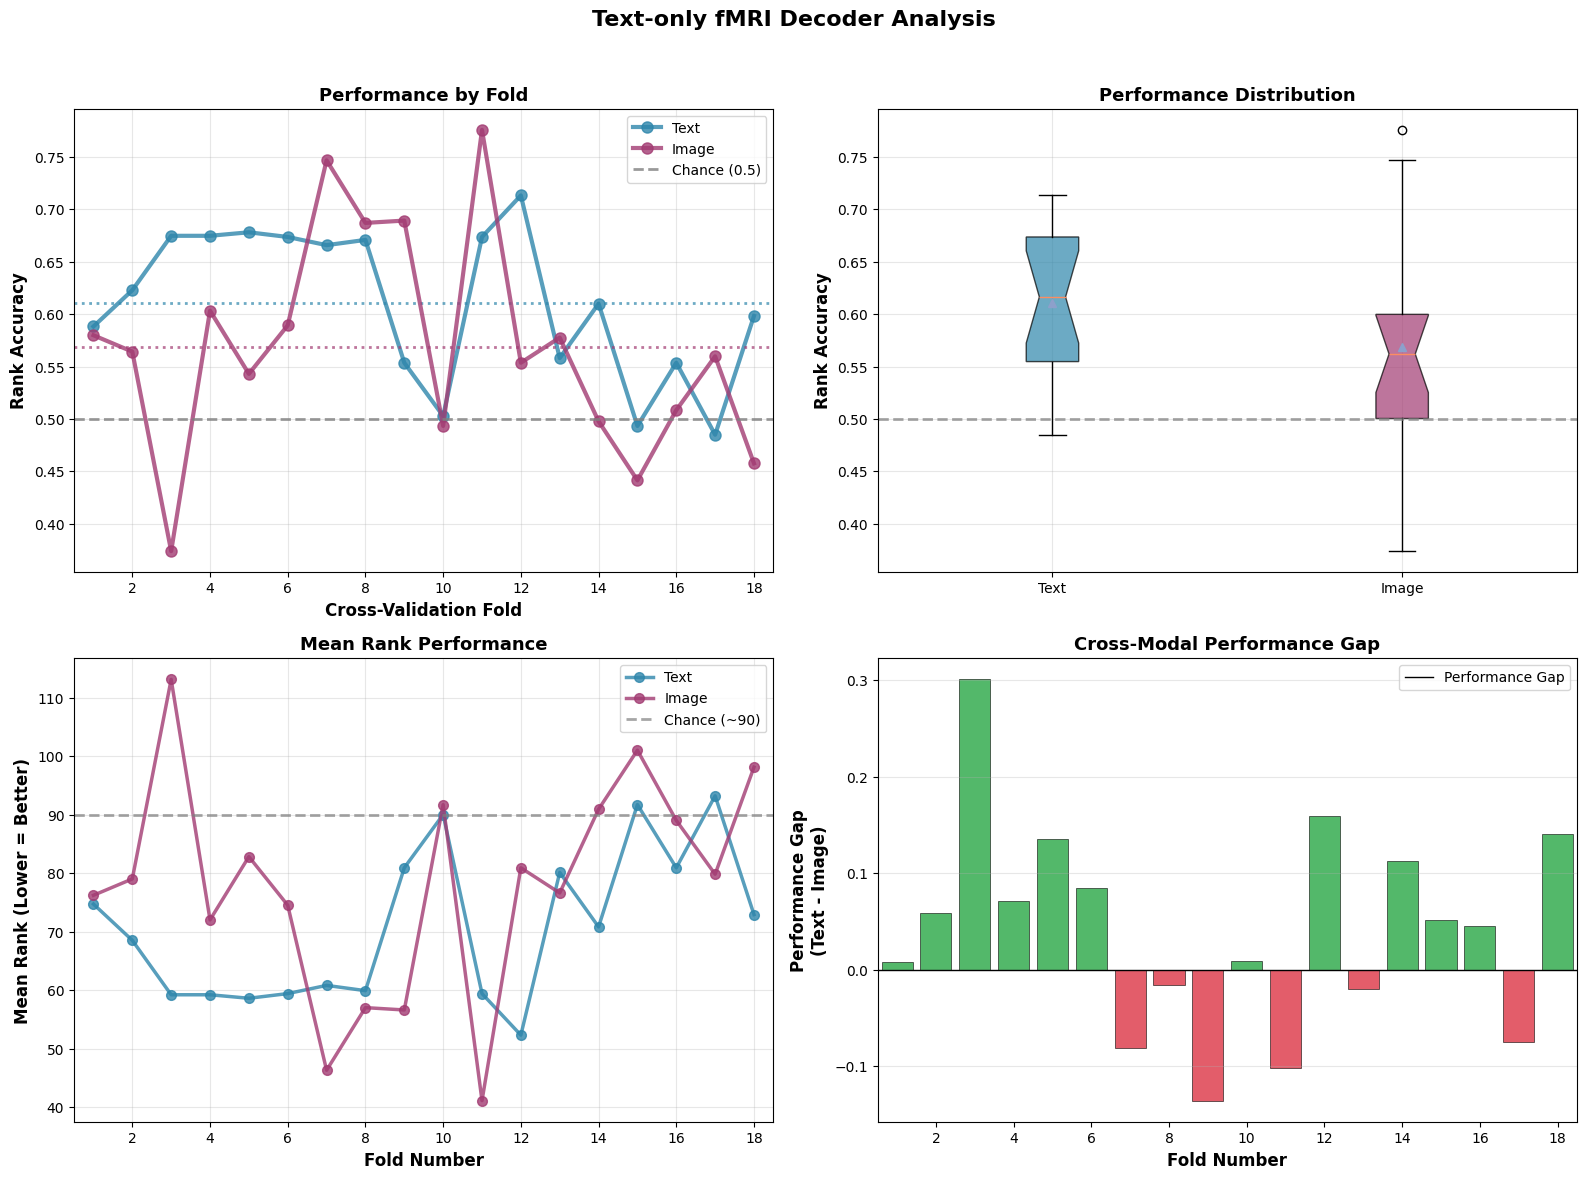


TEXT-ONLY FMRI DECODER ANALYSIS SUMMARY

TEXT EVALUATION:
  Mean Accuracy: 0.6106 ± 0.0704
  Range: [0.4849, 0.7134]
  Mean Rank: 70.7 ± 12.6
  Improvement: +22.1% over chance

IMAGE EVALUATION:
  Mean Accuracy: 0.5690 ± 0.1019
  Range: [0.3737, 0.7760]
  Mean Rank: 78.1 ± 18.2
  Improvement: +13.8% over chance


In [171]:
analysis_text, results_text = DecVTC_pipeline(
    text_embeddings=text_embeddings,
    img_embeddings=img_embeddings,
    img_concepts=img_concepts,
    concepts=concepts,
    fmri_text=fmri_text_data,
    grouping_method="mean",
    learn_decoder_fn=learn_decoder,
    mask_fn=mask_fmri_voxels,
    k=3
)

As we can see from all our results, the model we've learned is not very good. For unseen textual data across different folds, we're getting an acurracy of 61%, with an average rank of 71, which is quite bad (for comparison, the original Pereira paper got 74% rank accuracy, with an average rank of 47).

This means that even just for the same modality test, the basic metric we wanted to get to prove that our model works, we're getting very poor results. We do improve +22% over chance, which is undeniably a metric which implies **some** amount of learning and understanding, but it is much worse than the original paper, and pretty disappointing as a result. We also see in the graph at the bottom right (cross modal performance graph) that in almsot all folds, textual data was better predicted than image data. This is to be excepted, as we've only trained on textual data.

Moreover, if the picture looked grim when analyzing textual data, it gets even worse when we get to imaging data. As a reminder, our original hypothesis was that image data could be learned while only using textual data to train. This hypothesis, unfortunately, seems to be falling quite short. The average rank accuracy across folds stands on 56%, barely better than flipping a coin for it. The mean rank is 78, where chance is 90. These are not results that can help us say confidently that our hypothesis is correct. Actually, it almost certainly proves otherwise, at least in the setting that we've checked it. Those settings can be changed, and a lot of parameters and handles can be toggled with, even if we're still working on a linear model (the base embedding space, the grouping type, text ensembling in the pre-processing stage, etc.), but these results, which came from a very thorough analysis and after a lot of pre-processing to have clean and useful data, are a very good sign to determine that our **Our original hypothesis is incorrect**

This, though, is not a bad thing as of itself. Part of the research journey is to ask questions, and test them out. Not every hypothesis can be true, and figuring out that a hypothesis is incorrect is great, because at least you figured it out. The figuring out part is the journey, and journey comes before desination.

## Multi-modal to CLIP


We could have ended our analysis after the previous line, and detemining that our original hypothesis is incorrect. Analyzing something, even if incorrect, has a lot of value, because we can understand it better, and we understand the world of psycho-linguistic like never before.

But, even though failing is a part of the process, we didn't want to produce an output that's only a failed hypothesis. We went back to the drawing board, and tried to think of new hypotheses, new ways to decode the fMRI into a multi-modal embedding space. We came up with A LOT. But what we decided to try next was a multi-modal training of the model. As we saw earlier, the model did learn _some_ things, and it did so much more for the textual data than the imaging data. If there really is no other connection between the different parts of the brain when it comes to derive the meaning of the concept across modalities, than the way to define a relevant model would be to include _both_ parts of the brain that are relevant - the textual parts and the imaging parts. We decided to see what would happen if we trained on fmri data while masking it differently - this time, taking voxels that are influencial both to textual processing and image processing, acorrding to our univariate f-regression vectorized masking function.

Now, with a new hypothesis, we went back to try and analyze, and found a lot of problems with the original pipeline, so it also helped us to bring our idea of a unified pipeline to life much better. Because now the pipeline is done right, we'll see that the changes that we need to do are absolutely minimal - which was the entire point, to allow further analysis easily.

#### Data

##### Extract prerequisite data

Firstly, the data. Now, we are also training based on the fMRI data that was collected when people saw visual data, so we need to grab that data

In [172]:
import scipy.io

# Define constants
FMRI_IMAGE_PATH = "data/brain-responses-data/examples_180concepts_pictures.mat"

# Get the fMRI data, specifically for image fmri
image_mat = scipy.io.loadmat(FMRI_IMAGE_PATH)
fmri_image_data = image_mat["examples"]

#### Pre-processing

##### Masking

We also need to create a new masking - we want to get relevant voxels from each modality, and then create a finalized masked. The mask would be collision aware - if a voxels appears as important in multiple modalities, we would only take it once.

In [173]:
import numpy as np

def multimodal_mask_indices(modalities, num_voxels=5000):
    all_indices = set()
    for m in modalities:
        idx = mask_fmri_voxels(m["fmri"], m["sem"], num_voxels)
        all_indices.update(idx)
    return np.array(sorted(all_indices), dtype=int)


Because we're dealing with different training data, we need to create a slightly different function, that requires data we don't currently have withing our masking function. So, we'll just create a function that creates the relevant function, in order to stay as consistent as possible with the pipeline.

In [174]:
def create_multimodal_mask_fn(fmri_text, mask_size):
    def multimodal_mask_fn(train_X, train_Y, num_voxels=mask_size):
        # Split the training data back into text and image portions
        n_text = len(fmri_text)
        train_text_X = train_X[:n_text] if train_X.shape[0] > n_text else train_X
        train_img_X = train_X[n_text:] if train_X.shape[0] > n_text else np.array([]).reshape(0, train_X.shape[1])
        
        # Split the training targets back into text and image portions
        train_text_Y = train_Y[:n_text] if train_Y.shape[0] > n_text else train_Y
        train_img_Y = train_Y[n_text:] if train_Y.shape[0] > n_text else np.array([]).reshape(0, train_Y.shape[1])
        
        # Only use multimodal masking if we have both modalities in training
        if len(train_img_X) > 0:
            return multimodal_mask_indices(
                [
                    {"fmri": train_text_X, "sem": train_text_Y},
                    {"fmri": train_img_X, "sem": train_img_Y}
                ],
                num_voxels=num_voxels
            )
        else:
            # Fallback to single-modality masking
            return mask_fmri_voxels(train_text_X, train_text_Y, num_voxels)
    
    return multimodal_mask_fn

And that's it! We're already ok for running our pipeline again, with very little setup. Further extensibility would require some other small changes to the pipeline (for exapmle, if we're adding audio as another modality), but still, we leave a lot of room for later improvements.

Now, we get to see the multi_modal params we didn't get to see earlier - our new function that creates the masking function for the model, and the imaging data we extracted from our data folder. That's all of the difference!

Cross-validation folds: 100%|██████████| 18/18 [04:05<00:00, 13.63s/it]
C:\Users\user\AppData\Local\Temp\ipykernel_27644\2844251696.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=[et.title() for et in eval_types], patch_artist=True,


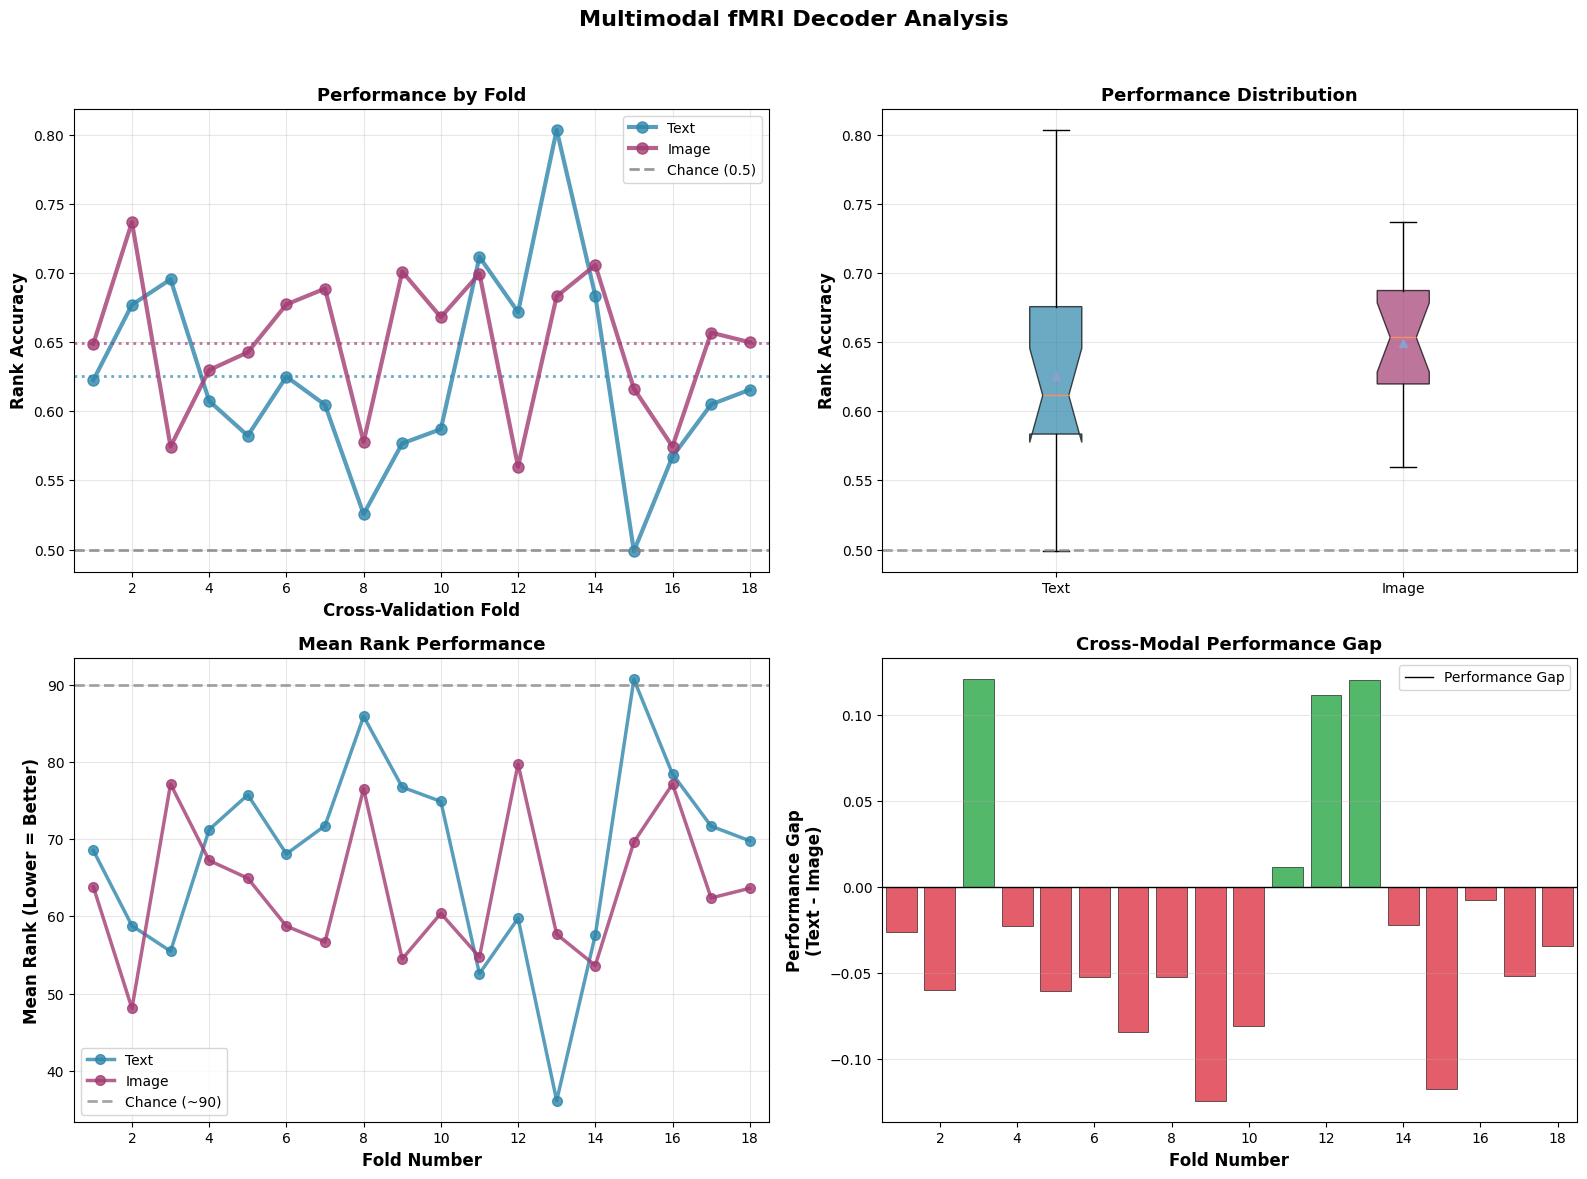


MULTIMODAL FMRI DECODER ANALYSIS SUMMARY

TEXT EVALUATION:
  Mean Accuracy: 0.6257 ± 0.0702
  Range: [0.4989, 0.8036]
  Mean Rank: 68.0 ± 12.6
  Improvement: +25.1% over chance

IMAGE EVALUATION:
  Mean Accuracy: 0.6496 ± 0.0504
  Range: [0.5601, 0.7369]
  Mean Rank: 63.7 ± 9.0
  Improvement: +29.9% over chance


In [175]:
analysis_multi_modal, results_multi_modal = DecVTC_pipeline (
    text_embeddings=text_embeddings,
    img_embeddings=img_embeddings,
    img_concepts=img_concepts,
    concepts=concepts,
    fmri_text=fmri_text_data,
    grouping_method="mean",
    learn_decoder_fn=learn_decoder,
    mask_fn=mask_fmri_voxels,
    create_multimodal_mask_fn=create_multimodal_mask_fn,
    fmri_image=fmri_image_data,
    multimodal=True,
    k=3
)

We can immediately see that the results are much better! The multimodal approach shows significant improvements across both evaluation types compared to the text-only model. This implies that our second hypothesis, that a linear decoder for cross modality from fMRI _can_ be achieved is correct!

## Model Comparison

Because of our analysis framework, we can visualize that improvement we discussed, without any further code!

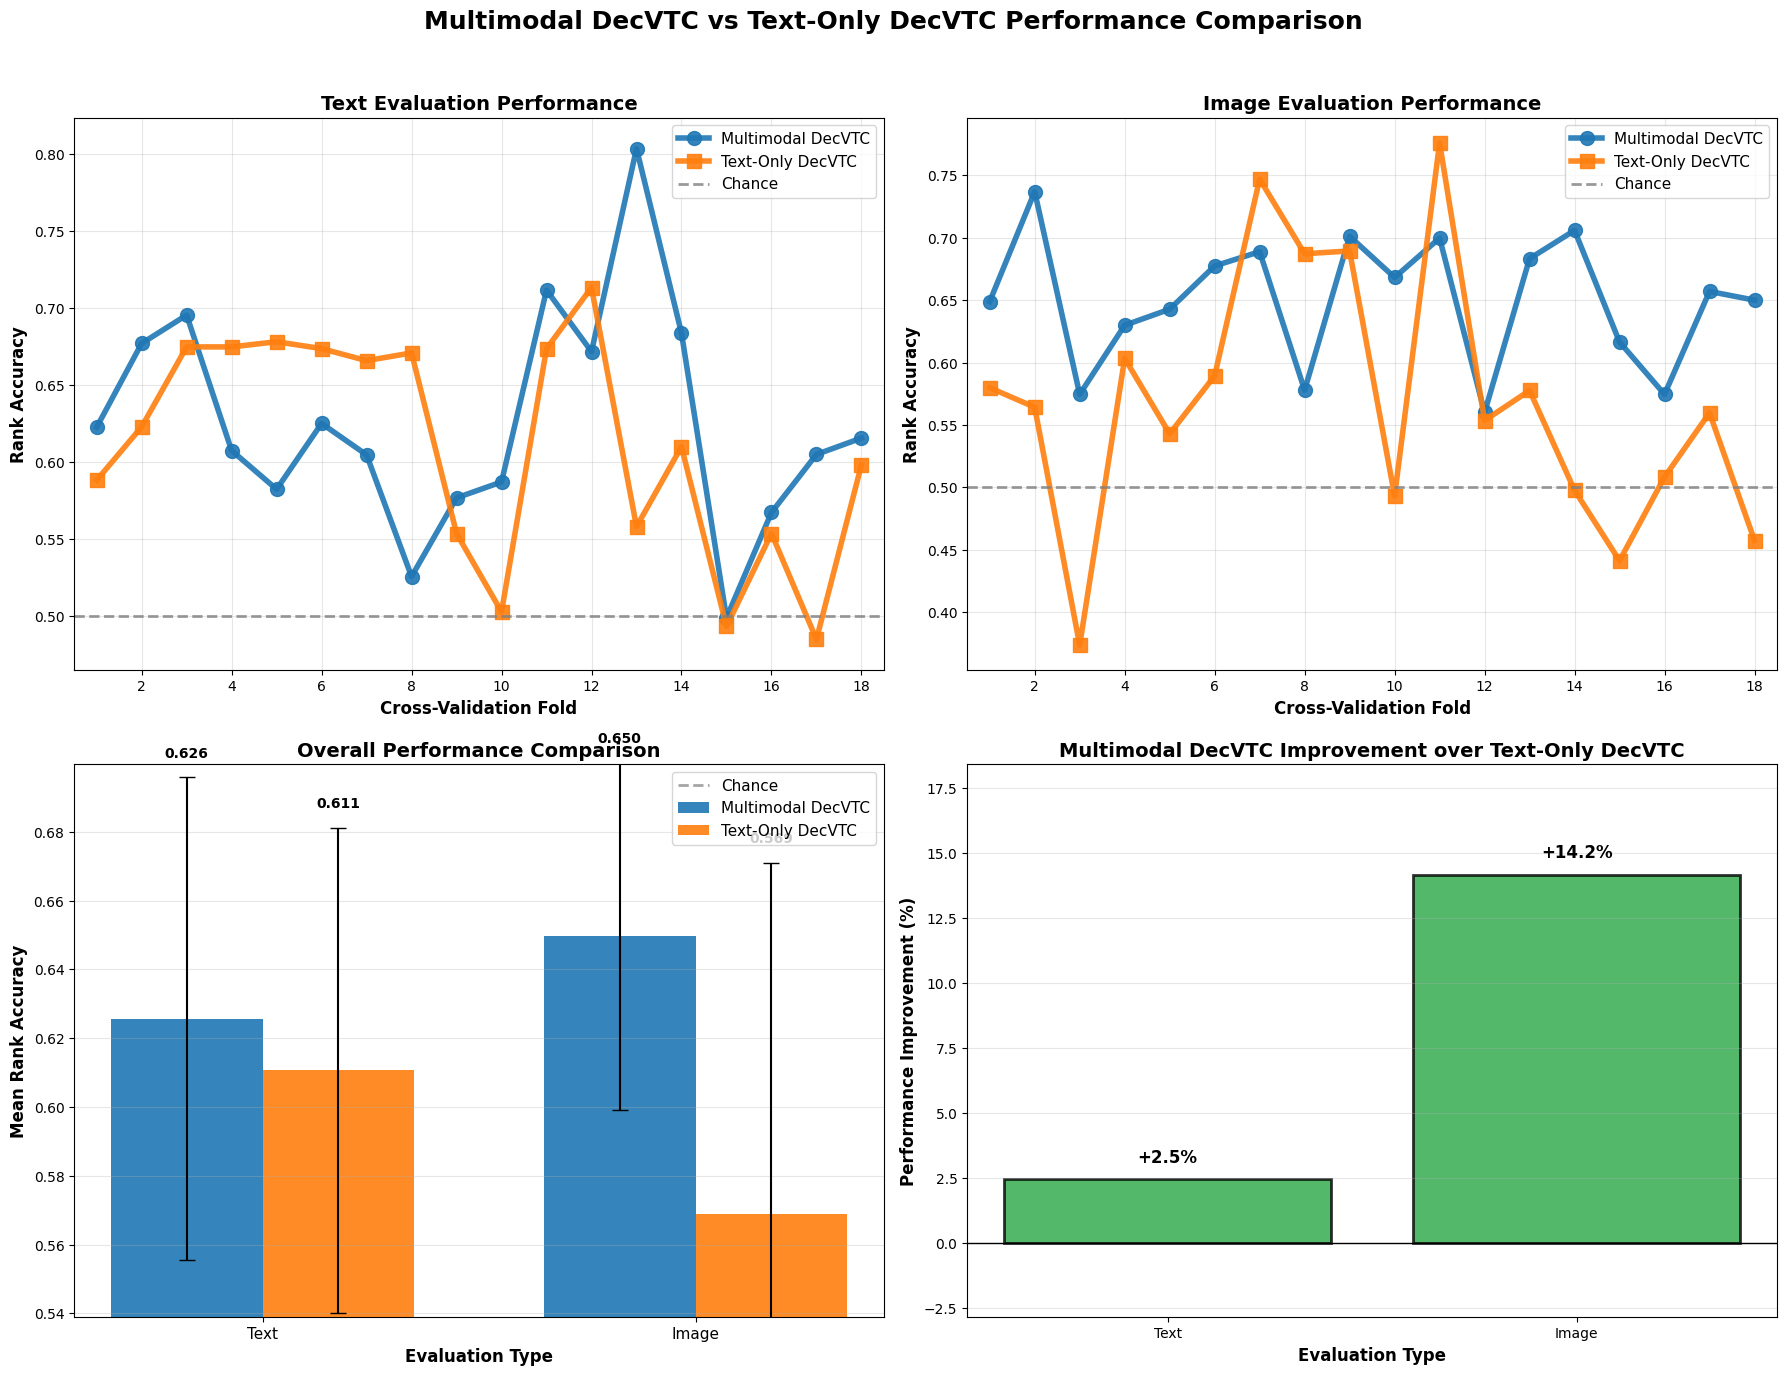

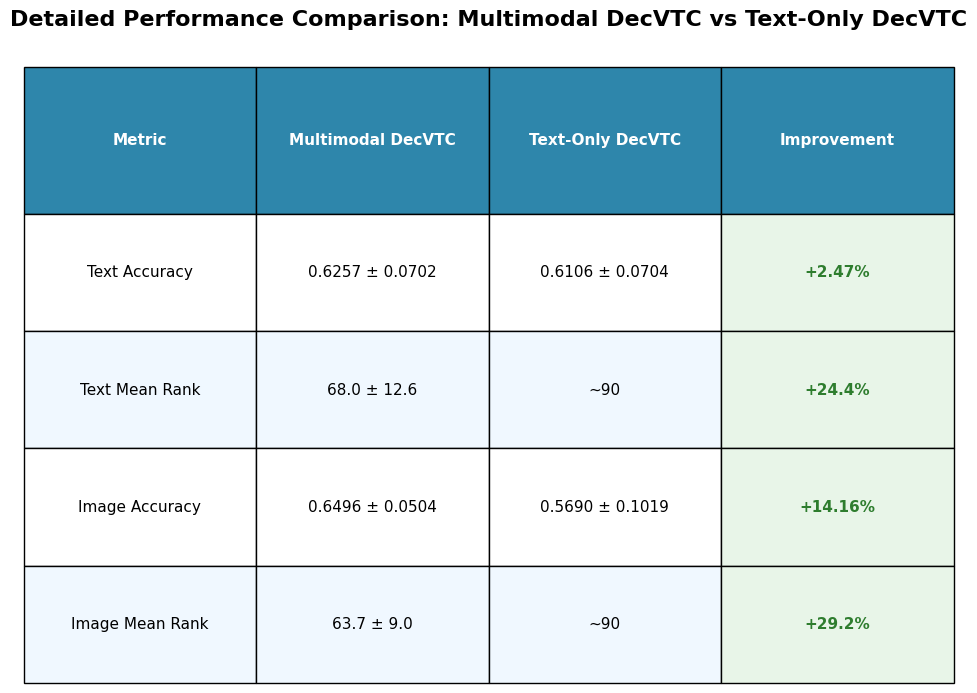


MULTIMODAL DECVTC VS TEXT-ONLY DECVTC COMPARISON

TEXT EVALUATION:
Multimodal DecVTC: 0.6257 ± 0.0702
Text-Only DecVTC: 0.6106 ± 0.0704
Improvement: +2.47%

IMAGE EVALUATION:
Multimodal DecVTC: 0.6496 ± 0.0504
Text-Only DecVTC: 0.5690 ± 0.1019
Improvement: +14.16%


In [176]:
comparison_analysis = analyze_fmri_model(
    results_multi_modal, 
    model_name="Multimodal DecVTC",
    comparison_results=results_text,
    comparison_name="Text-Only DecVTC"
)

**Text Evaluation Performance:**

- The multimodal model achieves higher rank accuracy on text evaluation compared to the text-only baseline (barely)
- This improvement occurs even though both models use the same text fMRI data during training
- The enhanced performance suggests that incorporating image-related brain regions provides complementary semantic information that benefits text understanding. Similar to the effect that textual data had on images (very little), we can see that training with the visual data also slightly improved the textual performance. This suggests that maybe meaning across modalities _is_ based on location, and not similar locations for image and text. The slight improvement is probably because of the collision voxels - the ones that are in both lists. These are not a lot, and that's why our first hypothesis proved to be wrong.

**Image Evaluation Performance:**

- The multimodal model shows substantial improvements in cross-modal generalization to images
- While the text-only model struggled with image evaluation (barely above chance at ~56%), the multimodal model demonstrates meaningful cross-modal transfer
- This validates our revised hypothesis that training on both text and image brain responses captures a more complete semantic representation

**Why the Multimodal Approach Works Better:**
1. Comprehensive Voxel Selection: The multimodal masking function identifies brain regions active during both text and image processing, capturing a broader semantic network than text-only masking
2. Joint Semantic Targets: By training on combined text+image embeddings (summed and renormalized), the model learns to map brain activity to a richer, more unified semantic space
3. Cross-Modal Brain Patterns: The model leverages brain regions that process semantic meaning regardless of input modality, leading to better generalization
4. Increased Training Data: Using both text and image fMRI data (360 total trials vs 180) provides more examples of how the brain encodes each concept

## Future work

Unfortunately, there is no way we could ever fit everything we wanted to do here. There are so many directions that this research could go to, that even doubling our 200 hour investment into the project wouldn't be enough. We did our best to keep things modular and extensible, so that if somehow people would be able to get this and work on the basis of this code and this project, it would be very easy, and they would have sufficient ways to go and research.

Some of the stuff that we wanted to do along the way:
- Ablations - the results of our multi-modal-evoked model are much better, but we didn't check if that's just a "fluke" of good params, or truly a pattern. From our testing, it does seem like a pattern, but we would really love to do many and more ablations, by keeping the baseline, and then playing with the parameters we can change. For all of these, nobody told us those are the "right" params - we either took them from the original paper of just saw they returned good results so we kept them:
    - The amount of voxels in the mask from each modality
    - The way we're grouping image embeddings (medoid/mean weren't used directly in the result, only the top-k mean based)
    - Fold size
- Ensembling and further text exploration - Unlike visual data, we only took one embedding vector for each concept here. It's well known that CLIP is prompt-sensitive, and we saw that ourselves, that's why we embeded it with a base prompt, but what could we do with a couple? Our text results were pretty static accross the board, but still quite far from the results of Pereira. Is that because of something we did wrong? Because of something in the embedding space?
- Different embedding spaces - as a continuation of my previous point, we really wanted to explore if the dropoff in textual accuracy vs the original paper (and a similar, if slightly better result, of visual data) is caused by the embedding space we explored. Does the embedding of both textual and visual data in the same embedding space cause a silent dropoff on how much meaning is encoded in the vectors, all while adding the (undeniably nice feature) of cross modality? Seems incredibly interesting.
- More data - The Pereira data, while good, is noisy, and we feared that including more than 1 person of the paper would cause a large dropoff in accuracy (very noisy for different people). Overall, even though there isn't a lot of data on the subject, figuring out how to add more fMRI data and convert it all to data for our decoder would probably add a lot of value (not only from Pereira, could be from Tukute, or any other datasets out there - we saw a few in our research, but it was too late to integrate them, as they are quite different from the Pereira one). If we can figure out how to smooth the noise, this could mean a big improvement in the model.
- Non-Linearity - This work (as same as Pereira, as we see it), is an exposition, a proof of concept that even with a linear decoder we can achieve some sort of understanding of language and meaning. Of course, LLMs have achieved incredible results, but not from an fMRI point of view, and if we can achieve good results with a linear model only, the sky are the limit for non-linear ones. We would have loved to add some deeper nueral networks learning into the mix, but we didn't have enough time unfortunately.

That's some of the things that we wanted to explore - not all of them, because writing them would be very long. The point of all of this is that we believe our work does prove something (with enough modalities, a mapping of where each modality is parsed in the brain, a ton of data and a better and faster imaging tech, we can achieve understading of any brainwave in real time, and make machines "read minds"), and of course going in that direction in the future could be extremely interesting and we hope that our work is thorough enough to provide such a basis if that would ever be relevant.